In [127]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.stats import beta
from tqdm.notebook import tqdm
import seaborn as sns

#load the jason file
file_path = r"C:\Users\sajad\Downloads\2armed_bandit.json"
with open(file_path, "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head(204)






rt                                           stimulus response  \
0    6946.0  <div style='color:white'>Welcome to our decisi...            
1    1287.0  <div style='color:white'>\n    <div class="slo...            
2    1130.0  <div style='color:white'>After selecting a ban...            
3     520.0  <div style='color:white'>Your goal is to earn ...            
4    1414.0  [<div class="slotmachine" style="position: abs...        0   
..      ...                                                ...      ...   
199     NaN           <div style='color:white'>Score: 63</div>     None   
200  1108.0  [<div class="slotmachine" style="position: abs...        0   
201     NaN           <div style='color:white'>Score: 63</div>     None   
202   610.0  [<div class="slotmachine" style="position: abs...        0   
203     NaN           <div style='color:white'>Score: 64</div>     None   

                 trial_type  trial_index  time_elapsed internal_node_id  \
0    html-keyboard-response            0          6951      0.0-0.0-0.0   
1    html-keyboard-response            1          8241      0.0-0.0-1.0   
2    html-keyboard-response            2          9372      0.0-0.0-2.0   
3    html-keyboard-response            3          9894      0.0-0.0-3.0   
4               html-choice            4         13317      0.0-1.0-0.0   
..                      ...          ...           ...              ...   
199  html-keyboard-response          199        374656     0.0-1.0-1.97   
200             html-choice          200        377776     0.0-1.0-0.98   
201  html-keyboard-response          201        378780     0.0-1.0-1.98   
202             html-choice          202        381398     0.0-1.0-0.99   
203  html-keyboard-response          203        382400     0.0-1.0-1.99   

     bean_trial_duration  bean_duration  \
0                    NaN            NaN   
1                    NaN            NaN   
2                    NaN            NaN   
3                    NaN            NaN   
4                    NaN            NaN   
..                   ...            ...   
199               1000.0         1000.0   
200                  NaN            NaN   
201               1000.0         1000.0   
202                  NaN            NaN   
203               1000.0         1000.0   

                                         bean_stimulus  ...  \
0    <div style='color:white'>Welcome to our decisi...  ...   
1    <div style='color:white'>"\n    <div class="sl...  ...   
2    <div style='color:white'>After selecting a ban...  ...   
3    <div style='color:white'>Your goal is to earn ...  ...   
4                                                  NaN  ...   
..                                                 ...  ...   
199           <div style='color:white'>Score: 63</div>  ...   
200                                                NaN  ...   
201           <div style='color:white'>Score: 63</div>  ...   
202                                                NaN  ...   
203           <div style='color:white'>Score: 64</div>  ...   

                                             bean_text bean_color  \
0    Welcome to our decision-making experiment. In ...      white   
1    "\n    <div class="slotmachine" style="positio...      white   
2    After selecting a bandit, you will receive fee...      white   
3    Your goal is to earn as many points as possibl...      white   
4                                                  NaN        NaN   
..                                                 ...        ...   
199                                          Score: 63      white   
200                                                NaN        NaN   
201                                          Score: 63      white   
202                                                NaN        NaN   
203                                          Score: 64      white   

    bean_correct value                                    bean_html_array  \
0          False   NaN     

In [ ]:

#keep only the rows from 4 to 204 which are the rows of the actual trials
df = df.iloc[4:204].copy()

#keep only essential columns
df = df[['trial_index', 'response', 'bean_value', 'bean_bandits']]

#rename the columns
df.rename(columns={
    'trial_index': 'trial',
    'response': 'choice',
    'bean_value': 'reward',
    'bean_bandits': 'bandit_info'
    }, inplace=True)

#reset the index
df.reset_index(drop=True, inplace=True)

print(df.head())


   trial choice  reward                                        bandit_info
0      4      0     0.0  [{'color': 'orange', 'value': 0}, {'color': 'b...
1      5   None     NaN                                                NaN
2      6      1     1.0  [{'color': 'orange', 'value': 1}, {'color': 'b...
3      7   None     NaN                                                NaN
4      8      1     1.0  [{'color': 'orange', 'value': 0}, {'color': 'b...


In [74]:
#our one-state env
class OneStepBanditEnv:
    def __init__(self, p_bandit0 = 0.8,             #probability of getting reward from the first bandit
                 p_bandit1 = 0.2,                   #robability of getting reward from the second bandit
                 reversal_trial = 50,               #changing the probabilities in after the half of the trials
                 n_trials = 100):
        self.p0_init = p_bandit0
        self.p1_init = p_bandit1
        self.reversal_trial = reversal_trial
        self.n_trials = n_trials
        self.trial = 0
        #current probabilities:
        self.p0 = p_bandit0
        self.p1 = p_bandit1
        self.done = False

    def reset(self):
        self.trial = 0
        self.p0 = self.p0_init
        self.p1 = self.p1_init
        self.done = False
        return None             #single-state env, so no real "state" to return
    
    def get_terminal_state(self):
        """
        Getter function for self.done
        """
        return self.done
    
    def get_trial_number(self):
        """
        Getter function for self.trial
        """
        return self.trial
    

    def step(self, action):
        """
        action: 0 or 1 for bandit choice
        returns: reward, done, info
        """
        #revers the probs when in the correct trial
        if self.trial == self.reversal_trial:
            old_p0 = self.p0
            self.p0 = self.p1
            self.p1 = old_p0

        #get reward from chosen bandit
        if action == 0:
            reward = np.random.binomial(1, self.p0)
        elif action== 1:
            reward = np.random.binomial(1, self.p1)
        else:
            raise ValueError("action must be 0 or 1")
        
        self.trial += 1
        terminate_trials = (self.trial >= self.n_trials)      #done after N_trials
        self.done = terminate_trials
        return reward, self.get_terminal_state()
        

In [105]:
def softmax(vals, beta):
    """
    Softmax function for action selection
    vals: The array of action values
    beta: Inverse temparature parameter for the softmax policy (higher beta -> more deterministic)
    return: The probabilities of each action, sums up to 1
    """

    """Compute softmax values for each sets of scores in x."""

    result = np.exp(vals * beta) / np.sum(np.exp(vals * beta))

    return result

In [89]:
class ModelFreeAgent:
    def __init__(self, learning_rate = 0.1, inverse_temp = 1.0):
        """
        a base agent for a single-state 2-bandit task
        learning_rate: learning rate
        inverse_temp: inverse temprature
        """
        self.learning_rate = learning_rate
        self.inverse_temp = inverse_temp
        self.Q_table = np.zeros(2)        #store Q for each action(2 actions)

    def get_action_probs(self):
        """
        return softmax probabilities for two bandits
        """
        probs = softmax(self.Q_table, self.inverse_temp)
        self.last_probs = probs
        return probs
    

    def policy(self):
        """
        choose an action using the softmax policy
        called in simulate()
        """
        probs = self.get_action_probs()
        action = np.random.choice([0,1], p= probs)
        return action
    
    def update_values(self, action, reward):
        """
        update the choosen action values using the Rescorla-Wagner rule
        called in simulate
        """

        rpe = reward - self.Q_table[action]
        self.Q_table[action] += self.learning_rate * rpe

In [77]:
class EpsilonGreedy:
    def __init__(self, epsilon = 0.99):
        self.n_arms = 2 # task only has 2 arms
        self.epsilon = epsilon
        self.counts = np.zeros(self.n_arms)  # Number of times each arm is pulled
        self.values = np.zeros(self.n_arms)  # Estimated values of each arm

    def get_epsilon(self):
        return self.epsilon

    def get_argmax(self):
        return np.argmax(self.values)
    

    def policy(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.n_arms)
        else:
            return np.argmax(self.values)

    def update_values(self, action, reward):
        self.counts[action] += 1
        n = self.counts[action]
        value = self.values[action]
        self.values[action] = ((n - 1) / n) * value + (1 / n) * reward

In [14]:
#Thompson Sampling Agent with decay
class ThompsonSamplingAgentDecay():
    def __init__(self, alpha0_arm0 = 1.0, beta0_arm0 = 1.0, alpha0_arm1 = 1.0, beta0_arm1 = 1.0, decay = 0.95):
        """
        alpha0 and beta0: initial Beta prior hyperparamrters
        """
        self.alphas = [alpha0_arm0, alpha0_arm1]
        self.betas = [beta0_arm0, beta0_arm1]
        self.decay = decay
        self.reset()

    def reset(self):
        self.alphas = [self.alphas[0], self.alphas[1]]
        self.betas = [self.betas[0], self.betas[1]]

    def get_beta_parameters(self):
        """
        Returns beta parameters pairwise for each beta distribution
        """
        bandit0_params = (self.alphas[0], self.betas[0])
        bandit1_params = (self.alphas[1], self.betas[1])
        return bandit0_params, bandit1_params


    def policy(self):
        #Overrides BaseAgent's policy() and returns an action by Thompson sampling from Beta distributions

        sample_0 = np.random.beta(self.alphas[0], self.betas[0])
        sample_1 = np.random.beta(self.alphas[1], self.betas[1])
        return 0 if sample_0 > sample_1 else 1
    
    def update_values(self, action, reward):
        #Overrides BaseAgent's update_values() and updates the chosen arm's Beta posterior

        #decay the existing posterior values
        self.alphas[action] *= self.decay
        self.betas[action] *= self.decay

        #update the chosen arm's posterior
        if reward == 1:
            self.alphas[action] += 1
        else:
            self.betas[action] += 1



In [68]:
def simulate_epsilon(env: OneStepBanditEnv, agent):
    """
    Returns dataset of one experiment with one participant
    :param env: environment
    :param agent: given agent
    :param trials: number of trials
    :return: simulated task data as a dataframe
    """

    env.reset()
    task_data = {}
    terminal = env.get_terminal_state()

    while terminal == False:
        # first stage choice
        trial_info = {}

        action = agent.policy()
        reward, terminal = env.step(action)
        agent.update_values(action, reward)
        best_action = np.argmax(agent.values)

        if action == best_action:
            prob_action = 1 - agent.epsilon + (agent.epsilon / env.n_trials)
        else:
            prob_action = agent.epsilon / env.n_trials
        
        #Data collection
        trial_info["action"] = action
        trial_info["reward"] = reward
        trial_info["prob_arm0"] = prob_action if action == 0 else 1 - prob_action
        trial_info["prob_arm1"] = prob_action if action == 1 else 1 - prob_action
        task_data[env.get_trial_number()] = trial_info

    return pd.DataFrame.from_dict(task_data, orient='index')

In [55]:
def simulate_thompson(env: OneStepBanditEnv, agent):
    """
    Simulate with given agent
    :param env: environment
    :param agent: given agent
    :param trials: number of trials
    :return: simulated task data as a dataframe
    """

    env.reset()
    task_data = {}
    terminal = env.get_terminal_state()

    while terminal == False:
        # first stage choice
        trial_info = {}

        action = agent.policy()
        reward, terminal = env.step(action)
        agent.update_values(action, reward)
        bandit0_params, bandit1_params = agent.get_beta_parameters()

        #Data collection
        trial_info["action"] = action
        trial_info["reward"] = reward
        trial_info["alpha0"] = bandit0_params[0] 
        trial_info["alpha1"] = bandit1_params[0] 
        trial_info["beta0"] = bandit0_params[1]
        trial_info["beta1"] = bandit1_params[1]
        task_data[env.get_trial_number()] = trial_info


    return pd.DataFrame.from_dict(task_data, orient='index')

In [94]:
def simulate_model_free(env: OneStepBanditEnv, agent):
    """
    Simulate with given agent
    :param env: environment
    :param agent: given agent
    :return: simulated task data as a dataframe
    """

    env.reset()
    task_data = {}
    terminal = env.get_terminal_state()

    while terminal == False:
        # first stage choice
        trial_info = {}

        action = agent.policy()
        reward, terminal = env.step(action)
        agent.update_values(action, reward)

        #Data collection
        trial_info["action"] = action
        trial_info["reward"] = reward
        trial_info["prob_0"] = agent.last_probs[0]
        trial_info["prob_1"] = agent.last_probs[1]
        trial_info["Q0"] = agent.Q_table[0]
        trial_info["Q1"] = agent.Q_table[1]
        task_data[env.get_trial_number()] = trial_info


    return pd.DataFrame.from_dict(task_data, orient='index')

In [95]:
np.random.seed(0)
env = OneStepBanditEnv()

agent_model_free = ModelFreeAgent()
data_model_free = simulate_model_free(env, agent_model_free)

agent_thompson_decay = ThompsonSamplingAgentDecay()
data_thompson_decay = simulate_thompson(env, agent_thompson_decay)

agent_epsilon = EpsilonGreedy()
data_epsilon = simulate_epsilon(env, agent_epsilon)


#print(data_thompson_decay)
#print(data_epsilon)
print(data_model_free)

     action  reward    prob_0    prob_1        Q0        Q1
1         1       0  0.500000  0.500000  0.000000  0.000000
2         1       0  0.500000  0.500000  0.000000  0.000000
3         0       1  0.500000  0.500000  0.100000  0.000000
4         0       0  0.524979  0.475021  0.090000  0.000000
5         1       0  0.522485  0.477515  0.090000  0.000000
..      ...     ...       ...       ...       ...       ...
96        0       0  0.408672  0.591328  0.412836  0.828166
97        0       1  0.397635  0.602365  0.471552  0.828166
98        1       1  0.411780  0.588220  0.471552  0.845349
99        0       0  0.407624  0.592376  0.424397  0.845349
100       0       0  0.396289  0.603711  0.381957  0.845349

[100 rows x 6 columns]


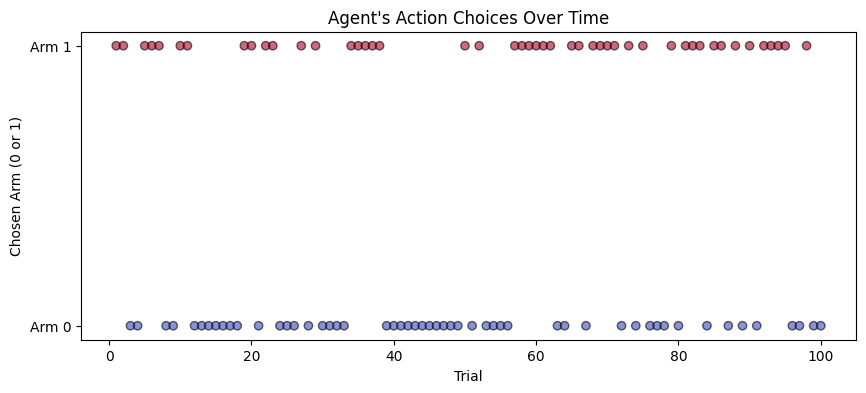

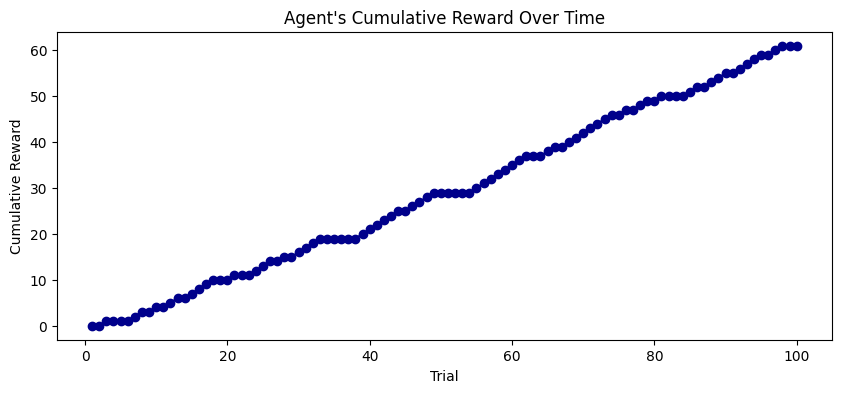

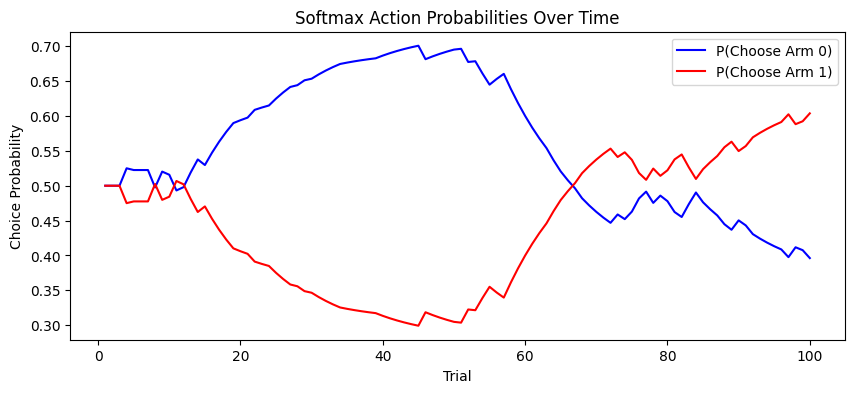

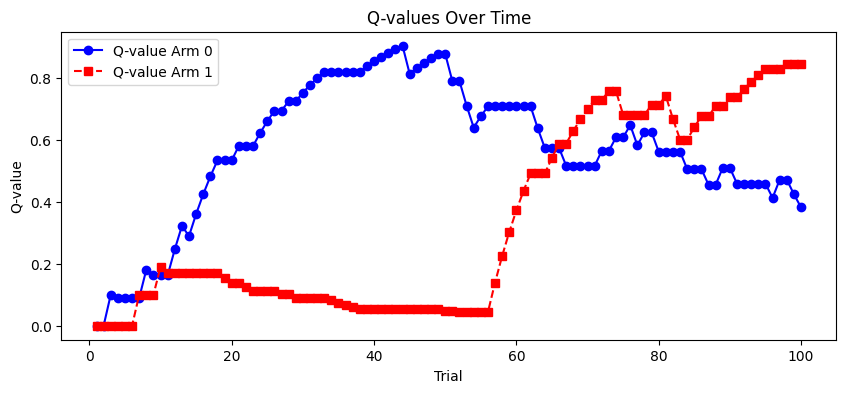

In [96]:
#Plots for Model-free agent
def plot_action_choices(data):
    """ Plots action choices over trials. """
    plt.figure(figsize=(10, 4))
    plt.scatter(data.index, data["action"], alpha=0.6, c=data["action"], cmap="coolwarm", edgecolors='k')
    plt.xlabel("Trial")
    plt.ylabel("Chosen Arm (0 or 1)")
    plt.title("Agent's Action Choices Over Time")
    plt.yticks([0, 1], labels=["Arm 0", "Arm 1"])
    plt.show()

def plot_cumulative_rewards(data):
    """ Plots cumulative rewards over trials. """
    data["cumulative_reward"] = data["reward"].cumsum()
    plt.figure(figsize=(10, 4))
    plt.plot(data.index, data["cumulative_reward"], marker="o", linestyle="-", color="darkblue")
    plt.xlabel("Trial")
    plt.ylabel("Cumulative Reward")
    plt.title("Agent's Cumulative Reward Over Time")
    plt.show()

def plot_q_values(data):
    """ Plots Q-values for each arm over trials. """
    plt.figure(figsize=(10, 4))
    plt.plot(data.index, data["Q0"], label="Q-value Arm 0", marker="o", linestyle="-", color="blue")
    plt.plot(data.index, data["Q1"], label="Q-value Arm 1", marker="s", linestyle="--", color="red")
    plt.xlabel("Trial")
    plt.ylabel("Q-value")
    plt.title("Q-values Over Time")
    plt.legend()
    plt.show()

def plot_action_probabilities(data):
    """ Plots softmax action probabilities over trials. """
    plt.figure(figsize=(10, 4))
    plt.plot(data.index, data["prob_0"], label="P(Choose Arm 0)", color="blue")
    plt.plot(data.index, data["prob_1"], label="P(Choose Arm 1)", color="red")
    plt.xlabel("Trial")
    plt.ylabel("Choice Probability")
    plt.title("Softmax Action Probabilities Over Time")
    plt.legend()
    plt.show()


plot_action_choices(data_model_free)
plot_cumulative_rewards(data_model_free)
plot_action_probabilities(data_model_free)
plot_q_values(data_model_free)

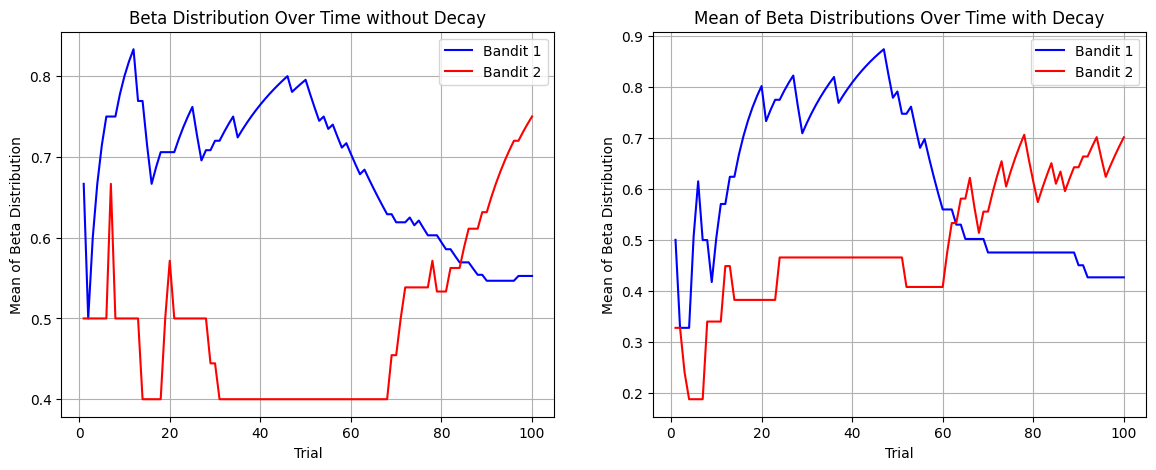

In [11]:
"""
Plotting Mean of Beta Distribution Over Time

"""
def plot_data(data,agent):
    plt.figure(figsize=(14, 5))
    # Plot for NoDecay agent
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(data["mean0"]) + 1), data["mean0"], linestyle='-', color='blue', label="Bandit 1")
    plt.plot(range(1, len(data["mean1"]) + 1), data["mean1"], linestyle='-', color='red', label="Bandit 2")

    plt.xlabel("Trial")
    plt.ylabel("Mean of Beta Distribution")
    plt.title(f"Beta Distribution Over Time for: {agent.get_name()}")
    plt.legend()
    plt.grid()

    # Show plot
    plt.show()

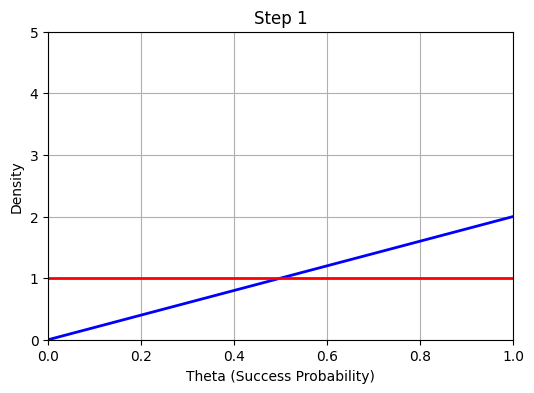

In [12]:
"""
Animation of Beta Distributions Over Time
WITH DECAY

"""

# X-axis values for Beta distribution
x = np.linspace(0, 1, 1000)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))
line1, = ax.plot([], [], 'b-', lw=2)
line2, = ax.plot([], [], 'b-', lw=2)
ax.set_xlim(0, 1)
ax.set_ylim(0, 5)
ax.set_xlabel("Theta (Success Probability)")
ax.set_ylabel("Density")
ax.set_title("Evolution of Beta Distribution with decay")
ax.grid()

# Update function for animation
def update(frame):
    # Compute Beta distribution
    y0 = beta.pdf(x, data_thompson_decay["alpha0"][frame+1], data_thompson_decay["beta0"][frame+1])
    y1 = beta.pdf(x, data_thompson_decay["alpha1"][frame+1], data_thompson_decay["beta1"][frame+1])

    # Update plot
    line1.set_data(x, y0)
    line1.set_color("blue")
    line2.set_data(x, y1)
    line2.set_color("red")
    ax.set_title(f"Step {frame+1}")
    return line1, line2

# Create animation
ani = animation.FuncAnimation(fig, update, frames=env.get_trial_number(), blit=False, interval=200)

HTML(ani.to_jshtml())

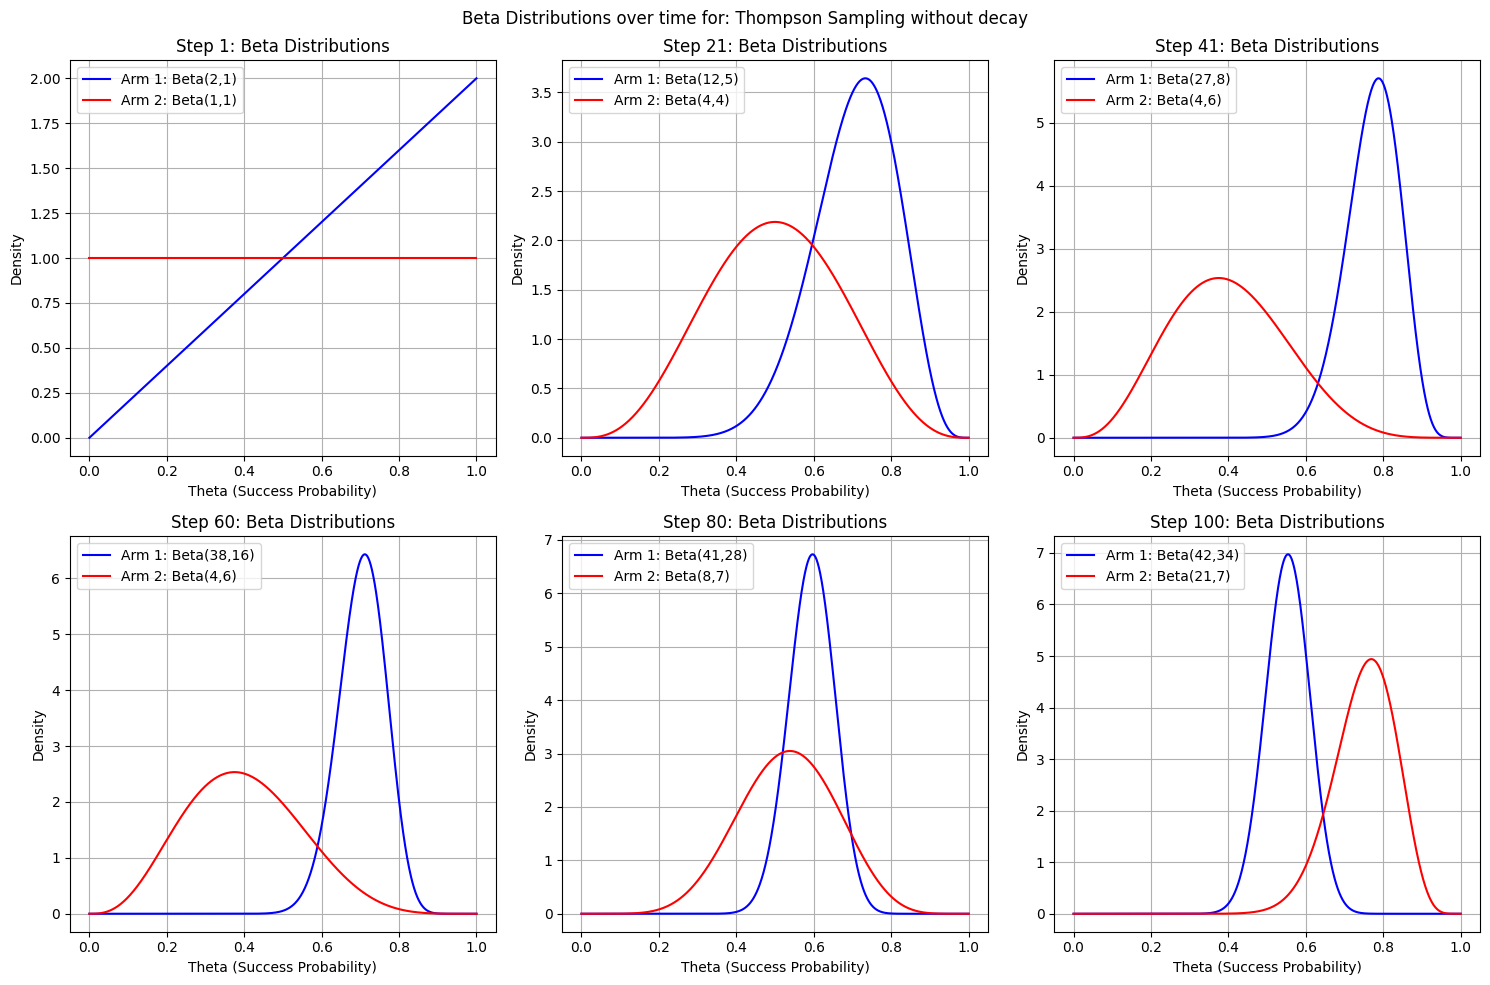

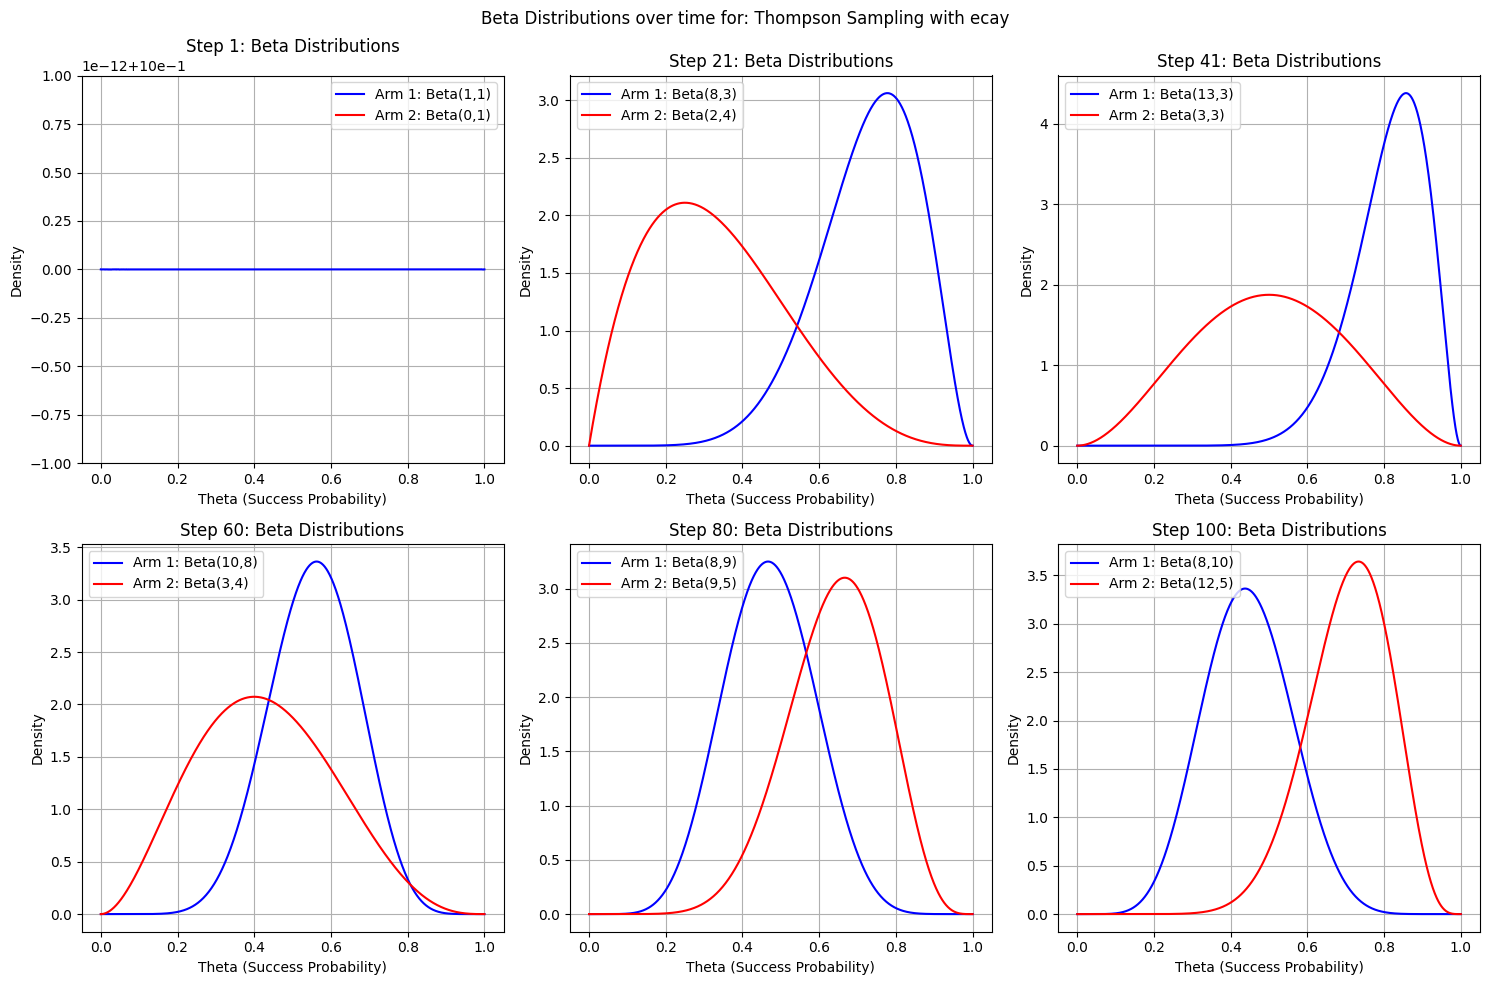

In [14]:
"""
Beta Distributions at different time steps

"""

def plot_overTime(data, agent):
    # X-axis values for Beta distribution
    x = np.linspace(0, 1, 1000)

    # Set up the figure and subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns
    fig.suptitle(f"Beta Distributions over time for: {agent.get_name()}")
    axes = axes.flatten()  # Flatten axes array for easy indexing


    for i, trial in enumerate(np.linspace(1, env.get_trial_number(), 6)):
        trial = int(np.round(trial))
        #get params
        alpha0 = round(data["alpha0"][trial],2)
        alpha1 = round(data["alpha1"][trial],2)
        beta0 = round(data["beta0"][trial],2)
        beta1 = round(data["beta1"][trial],2)

        # Compute Beta distribution
        y0 = beta.pdf(x, alpha0, beta0)
        y1 = beta.pdf(x, alpha1, beta1)

        # Plot the Beta distributions for arm 1 and arm 2 at time t
        axes[i].plot(x, y0, label=f"Arm 1: Beta({alpha0},{beta0})", color='blue')
        axes[i].plot(x, y1, label=f"Arm 2: Beta({alpha1},{beta1})", color='red')

        # Title and labels
        axes[i].set_title(f"Step {trial}: Beta Distributions")
        axes[i].set_xlabel("Theta (Success Probability)")
        axes[i].set_ylabel("Density")
        axes[i].legend()
        axes[i].grid()

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [101]:
def run_simulation(n_runs = 50, n_trials = 100, random_seed = 42):
    """
    Example driver function to create many synthetic participants
    from each TS agent (with or without decay), each with random parameters.

    :param n_runs: how many participants to simulate PER agent class
    :param n_trials: number of trials in OneStepBanditEnv
    :param random_seed: seed for reproducibility
    :return: A single DataFrame with all simulation data
    """
    np.random.seed(random_seed)

    df_surrogated = []

    #simulate from TS with decay
    for run_idx in range(n_runs):
        #create a new env for each participant
        env = OneStepBanditEnv(n_trials= n_trials)

        #create a new agent for each participant
        decay_agent = ThompsonSamplingAgentDecay(decay = np.random.uniform(0.9, 0.99))

        #run the simulation
        df_run = simulate_thompson(env, decay_agent)

        #add participant ID
        df_run["run_id"] = run_idx
        df_run["model_name"] = "TS_decay"
        df_run["true_decay"] = decay_agent.decay
        #append to list
        df_surrogated.append(df_run)

    #Simulate from Epsilon-Greedy with Decay
    """"for run_idx in range(n_runs):
        # Create a new environment for each participant
        env = OneStepBanditEnv(n_trials=n_trials)

        epsgreedy_agent = EpsilonGreedy(epsilon = np.random.uniform(0.001 , 0.4))

        # Run the simulation (you'll implement something like simulate_epsilon)
        df_run = simulate_epsilon(env, epsgreedy_agent)

        # Add identifying info
        df_run["run_id"] = run_idx
        df_run["model_name"] = "EGreedy"
        df_run["true_epsilon"] = epsgreedy_agent.epsilon

        df_surrogated.append(df_run)"""

    
    #simulate from model-free agent
    for run_idx in range(n_runs):
        #create a new env for each participant
        env = OneStepBanditEnv(n_trials= n_trials)

        #create a new agent for each participant
        model_free_agent = ModelFreeAgent(learning_rate = np.random.uniform(0.01, 0.9), inverse_temp = np.random.uniform(1, 5))

        #run the simulation
        df_run = simulate_model_free(env, model_free_agent)

        #add participant ID
        df_run["run_id"] = run_idx
        df_run["model_name"] = "ModelFree"
        df_run["true_learning_rate"] = model_free_agent.learning_rate
        df_run["true_inverse_temp"] = model_free_agent.inverse_temp
        #append to list
        df_surrogated.append(df_run)
    #combine all dataframes into one
    df_surrogated = pd.concat(df_surrogated)

    return df_surrogated

In [102]:
test_sim = run_simulation(10, 100, 42)
print(test_sim)

     action  reward    alpha0  alpha1     beta0  beta1  run_id model_name  \
1         0       0  0.933709     1.0  1.933709    1.0       0   TS_decay   
2         0       1  1.871812     1.0  1.805520    1.0       0   TS_decay   
3         0       1  2.747727     1.0  1.685830    1.0       0   TS_decay   
4         0       1  3.565576     1.0  1.574074    1.0       0   TS_decay   
5         0       1  4.329209     1.0  1.469726    1.0       0   TS_decay   
..      ...     ...       ...     ...       ...    ...     ...        ...   
96        1       1       NaN     NaN       NaN    NaN       9  ModelFree   
97        1       1       NaN     NaN       NaN    NaN       9  ModelFree   
98        1       0       NaN     NaN       NaN    NaN       9  ModelFree   
99        0       0       NaN     NaN       NaN    NaN       9  ModelFree   
100       1       1       NaN     NaN       NaN    NaN       9  ModelFree   

     true_decay    prob_0    prob_1        Q0        Q1  true_learning_rate

In [122]:
def compute_log_likelihood_model_free(data, learning_rate, inverse_temp):
    """
    Computes the log-likelihood of the observed choices under the Model-Free RL agent.

    Parameters:
        data: DataFrame containing trials (columns: 'action', 'reward')
        learning_rate: Learning rate parameter (alpha)
        inverse_temp: Inverse temperature parameter (beta)
    
    Returns:
        log-likelihood score
    """
    log_likelihood = 0
    Q = np.zeros(2)  # Initialize Q-values for both arms

    for _, row in data.iterrows():
        probs = softmax(Q, inverse_temp)
        action = int(row["action"])
        reward = row["reward"]
        
        log_likelihood += np.log(probs[action] + 1e-10)  # Avoid log(0)
        
        # Update Q-values using Rescorla-Wagner rule
        Q[action] += learning_rate * (reward - Q[action])

    return log_likelihood

In [116]:
def compute_log_likelihood_TS(agent, data, num_samples=1000):
    """
    Compute log-likelihood of observed choices by running the agent through trials.

    Args:
        agent: Thompson Sampling agent with `select_action()` and `update()` methods.
        data: DataFrame containing observed choices (`action`, `reward`).
        num_samples: Number of Monte Carlo samples for estimating choice probabilities.

    Returns:
        log-likelihood value.
    """
    log_likelihood = 0

    for _, row in data.iterrows():
        # Get observed action and reward
        observed_action = int(row['action'])
        reward = row['reward']

        #get current beta params from the agent
        bandit0_params, bandit1_params = agent.get_beta_parameters()
        a0, b0 = bandit0_params
        a1, b1 = bandit1_params

        #sample from beta distributions
        samples_0 = beta.rvs(a0, b0, size=num_samples) # monte carlo sampling for arm 0
        samples_1 = beta.rvs(a1, b1, size=num_samples) # monte carlo sampling for arm 1

        #compute choice probability
        probs = [0, 0]
        probs[0] = np.mean(samples_0 > samples_1)  # arm 0
        probs[1] = 1 - probs[0]  # arm 1

        # Compute log-likelihood for the observed action
        log_likelihood += np.log(probs[observed_action] + 1e-10)  # Add small constant to avoid log(0)

        # Update agent with the observed reward
        agent.update_values(observed_action, reward)

    return log_likelihood

In [123]:
# Create an environment
env = OneStepBanditEnv(n_trials=100)

agent_thompson = ThompsonSamplingAgentDecay(decay=0.95)
data_thompson = simulate_thompson(env, agent_thompson)

agent_model_free = ModelFreeAgent()
data_model_free = simulate_model_free(env, agent_model_free)
# Compute log-likelihood
ll = compute_log_likelihood_model_free(data_model_free, learning_rate= 0.4, inverse_temp=2)

print(ll)

-69.06485704336092


In [104]:
"""def compute_log_likelihood_EG(agent, data, num_samples=1000):
    
    Compute log-likelihood of observed choices by running the agent through trials.

    Args:
        agent: Thompson Sampling agent with `select_action()` and `update()` methods.
        data: DataFrame containing observed choices (`action`, `reward`).
        num_samples: Number of Monte Carlo samples for estimating choice probabilities.

    Returns:
        log-likelihood value.
    
    log_likelihood = 0

    for _, row in data.iterrows():
        # Get observed action and reward
        observed_action = row['action']
        reward = row['reward']

        #sample from beta distributionsr
        samples_0 = beta.rvs(a0, b0, size=num_samples) # monte carlo sampling for arm 0
        samples_1 = beta.rvs(a1, b1, size=num_samples) # monte carlo sampling for arm 1

        #compute choice probability
        probs = []
        probs[0] = np.mean(samples_0 > samples_1)  # arm 0
        probs[1] = 1 - prob_0  # arm 1

        # Compute log-likelihood for the observed action
        log_likelihood += np.log(probs[observed_action] + 1e-10)  # Add small constant to avoid log(0)

        # Update agent with the observed reward
        agent.update_values(observed_action, reward)

    return log_likelihood"""

"def compute_log_likelihood_EG(agent, data, num_samples=1000):\n    \n    Compute log-likelihood of observed choices by running the agent through trials.\n\n    Args:\n        agent: Thompson Sampling agent with `select_action()` and `update()` methods.\n        data: DataFrame containing observed choices (`action`, `reward`).\n        num_samples: Number of Monte Carlo samples for estimating choice probabilities.\n\n    Returns:\n        log-likelihood value.\n    \n    log_likelihood = 0\n\n    for _, row in data.iterrows():\n        # Get observed action and reward\n        observed_action = row['action']\n        reward = row['reward']\n\n        #sample from beta distributionsr\n        samples_0 = beta.rvs(a0, b0, size=num_samples) # monte carlo sampling for arm 0\n        samples_1 = beta.rvs(a1, b1, size=num_samples) # monte carlo sampling for arm 1\n\n        #compute choice probability\n        probs = []\n        probs[0] = np.mean(samples_0 > samples_1)  # arm 0\n        pr

In [125]:
def param_search(env, agent_class, data, param_space):

    """
    Args:
      env (TwoStepEnv)
      data (DataFrame)):       Obtained from participants or via simulation
      param_space (dict):      Specifies the search values for parameters
                               alpha and beta
    """

    LL_matrix = []
    best_param = 0.0
    best_LL = -np.inf

    for i, param in enumerate(tqdm(param_space)):

        # Initialize an agent
        agent = agent_class(param)

        if isinstance(agent_class,ThompsonSamplingAgentDecay):
          LL = compute_log_likelihood_TS(agent, data)
        else:
          LL = compute_log_likelihood_model_free(agent, data)

        LL_matrix.append(LL)

        # Update the best_LL, best_alpha and best_beta
        if (LL > best_LL):
          best_LL =    LL
          best_param =  param

    return best_param, best_LL, LL_matrix

In [128]:
def param_recovery(agent_class, param_range=[0.65,1], num_runs=20):
    param_space = np.random.uniform(param_range[0], param_range[1], num_runs)
    fitted_params = []
    best_LLs = []
    env = OneStepBanditEnv()

    for run, param in enumerate(tqdm(param_space)):

      # simulate the data
      agent = agent_class(param)

      if isinstance(agent_class,ThompsonSamplingAgentDecay):
        data = simulate_thompson(env, agent)
      else:
        data = simulate_epsilon(env, agent)

      best_param, best_LL, _ = param_search(env, agent_class, data, param_space)

      #store the fitted parameters and the true parameters
      fitted_params.append(best_param)
      best_LLs.append(best_LL)

    return fitted_params, param_space, best_LLs

In [130]:
fitted_param_thompson, true_param_thompson, best_ll_thompson_list = param_recovery(agent_class=ThompsonSamplingAgentDecay)
#fitted_param_thompson, true_param_thompson, best_ll_thompson_list = param_recovery(agent_class=EpsilonGreedy)

  0%|          | 0/20 [00:00<?, ?it/s]

AttributeError: 'ThompsonSamplingAgentDecay' object has no attribute 'values'

In [129]:
from scipy.stats import pearsonr
def plot_param_recovery(true_params, fitted_params, title='', max_plots_per_row:int=3, save=False, filename:str='plots/param_recovery.png'):
    n_params = len(true_params)

    rows = (n_params - 1) // max_plots_per_row + 1  # ensure at least one row
    cols = min(n_params, max_plots_per_row)

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6*cols, 6*rows))
    fig.suptitle(title)
    axes = axes.flatten()

    for i, param in enumerate(true_params.keys()):
        ax = axes[i]
        true_values = np.array(true_params[param])
        fitted_values = np.array(fitted_params[param])
        sns.scatterplot(x=true_values, y=fitted_values, ax=ax)
        ax.set_title(f'{param}')
        ax.set_xlabel('true')
        ax.set_ylabel('fitted')

        # plot the identity line based on combined min and max of true and fitted values
        combined_values = np.concatenate([true_values, fitted_values])
        min_val, max_val = combined_values.min(), combined_values.max()
        ax.plot([min_val, max_val], [min_val, max_val], ls="--", c=".3")

        # print pearson correlation
        corr_coef_scipy, p_value = pearsonr(true_values, fitted_values)
        print(f'Pearson correlation for {param}: {corr_coef_scipy:.3f}, p_value: {p_value}')

    fig.tight_layout()
    plt.show()

def plot_param_correlation(fitted_params:dict, title='', save=False, filename='plots/recovered_param_correlation.png'):
    # print the correlation uisng scipy pearson
    param_names = list(fitted_params.keys())

    corr = pearsonr(fitted_params[param_names[0]], fitted_params[param_names[1]])
    print(f'corr_1: {corr}')
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.suptitle(title + ' Correlation: ' + f'{corr[0]:.3f}')
    sns.scatterplot(data=fitted_params, x=param_names[0], y=param_names[1], ax=ax)
    ax.set_title(f'{title}_1')
    plt.show()